In [2]:
!pip install pandas
import pandas as pd
#merge datasets together
df2 = pd.read_csv("era5_heat_index_daily_il_counties_2024.csv")
df2.groupby("county")[[
    "heat_index_mean", 
    "heat_index_max", 
    "heat_index_min", 
    "heat_index_hours_above_90", 
    "heat_index_hours_above_104"
]].mean().reset_index()


,county,heat_index_mean,heat_index_max,heat_index_min,heat_index_hours_above_90,heat_index_hours_above_104
0,"Adams County, IL",55.216495,65.289755,45.370817,0.811475,0.051913
1,"Alexander County, IL",60.774260,70.766492,51.234406,1.330601,0.117486
2,"Bond County, IL",57.559627,67.355089,48.091005,0.907104,0.032787
3,"Boone County, IL",50.725086,59.740267,41.461138,0.267760,0.019126
4,"Brown County, IL",55.185470,65.299251,45.272393,0.803279,0.051913
...,...,...,...,...,...,...
97,"Whiteside County, IL",52.341675,62.092340,42.783508,0.459016,0.038251
98,"Will County, IL",52.844786,62.015580,43.549462,0.448087,0.021858
99,"Williamson County, IL",59.823319,69.715721,50.467351,1.128415,0.043716
100,"Winnebago County, IL",50.812278,60.073366,41.388649,0.292350,0.021858


In [3]:
import glob
from pathlib import Path

def load_syndromic(files):
    df_list = []
    for f in files:
        try:
            tmp = pd.read_csv(
                f,
                usecols=["HospitalRegion"],
                engine="python",
                encoding="utf-8",
                on_bad_lines="skip"
            )
            df_list.append(tmp)
        except Exception as e:
            print(f" Error reading {f}: {e}")
    if not df_list:
        return pd.DataFrame()
    return pd.concat(df_list, ignore_index=True)


base_path = Path.cwd().parents[1]


health_path_2024 = base_path / "essence" / "syndromic" / "2024"
files_2024 = list(health_path_2024.glob("*.csv"))

print(f" Found {len(files_2024)} CSV files for 2024")


health_2024 = load_syndromic(files_2024)


if not health_2024.empty:
    print("Data loaded successfully")
    print("Shape:", health_2024.shape)
    print(health_2024.head())
else:
    print("No valid data was loaded for 2024")
print("Shape:", health_2024.shape)

 Found 366 CSV files for 2024
Data loaded successfully
Shape: (5823734, 1)
  HospitalRegion
0          Logan
1          Logan
2          Logan
3          Logan
4          Logan
Shape: (5823734, 1)


In [4]:
region_counts = health_2024.groupby("HospitalRegion").size().reset_index(name="visit_count")
df2["county_clean"] = df2["county"].str.replace(" County, IL", "", regex=False)

county_vists = {}
for i, row in df2.iterrows():
    county = row["county_clean"]
    match = region_counts[region_counts["HospitalRegion"].str.lower()==county.lower()]
    if not match.empty:
        county_vists[row["county"]]=int(match["visit_count"].values[0])
    else:
        county_vists[row["county"]] = None

In [5]:
df2["visit_count"] = df2["county"].map(county_vists)
df_match= df2.dropna(subset=["visit_count"])
only_numeric = ["heat_index_mean", "heat_index_max", "heat_index_min", "heat_index_hours_above_90", "heat_index_hours_above_104", "visit_count"]

corr = df_match[only_numeric].corr()
print(corr)

                            heat_index_mean  heat_index_max  heat_index_min  \
heat_index_mean                    1.000000        0.982988        0.977339   
heat_index_max                     0.982988        1.000000        0.930491   
heat_index_min                     0.977339        0.930491        1.000000   
heat_index_hours_above_90          0.437804        0.457620        0.413461   
heat_index_hours_above_104         0.144394        0.165186        0.124207   
visit_count                       -0.038621       -0.051104       -0.026021   

                            heat_index_hours_above_90  \
heat_index_mean                              0.437804   
heat_index_max                               0.457620   
heat_index_min                               0.413461   
heat_index_hours_above_90                    1.000000   
heat_index_hours_above_104                   0.391894   
visit_count                                 -0.039958   

                            heat_index_hours_a

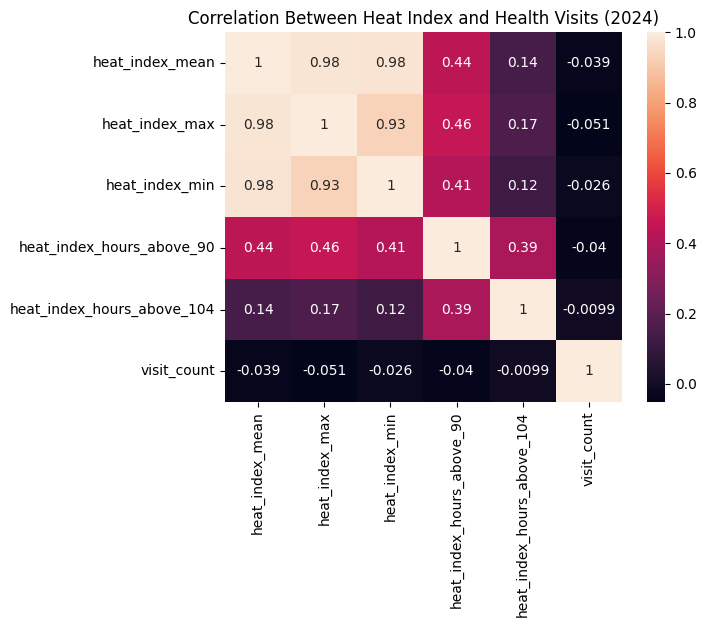

In [6]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(corr, annot=True)
plt.title("Correlation Between Heat Index and Health Visits (2024)")
plt.show()